In [1]:
import tqdm 
from model import VAE, VAELoss 
from utils import * 
import json 

import torch 
import torch.optim as optim 
from torch.utils.data import DataLoader
import torchvision.transforms as transforms

import matplotlib.pyplot as plt

In [2]:
# Define transformations
transform = transforms.Compose([
    transforms.Resize((24, 24)),  
    transforms.ToTensor()         
])

# Create the dataset
dataset = CryptoPunksDataset(transform=transform)

# Create the DataLoader
batch_size = 64
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

Data already unzipped.


In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VAE(input_channels=4, hidden_dims=128, latent_dim=64, output_channels=4).to(device)

model.load_state_dict(torch.load('./variational_autoencoder_30e.pth'))

optimizer = optim.Adam(model.parameters(), lr=1e-3)
criteria = VAELoss() 

training_losses = [] 

for epoch in (progress := tqdm.tqdm(range(1, 21))): 

    model.train()
    train_loss = 0

    for batch_idx, data in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = criteria(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()

        training_losses.append(loss.item() / len(data))
        progress.set_description(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item() / len(data):.6f}')

Train Epoch: 20 [2496/10000 (99%)]	Loss: 221.352707: 100%|██████████| 20/20 [12:22<00:00, 37.13s/it]


In [10]:
torch.save(model.state_dict(), './variational_autoencoder_10e_NUMPY.pth')

In [11]:
num_samples = 3  
samples = model.sample(num_samples, device)
samples = samples.detach().cpu().numpy()

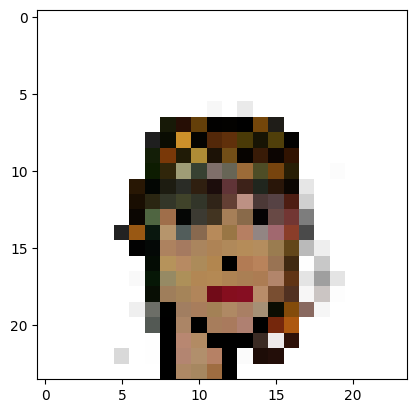

In [14]:
# Example: Display the first sample
plt.imshow(samples[2].transpose(1, 2, 0).astype(float))  
plt.show()